# Simulation of Aging Through Damage Accumulation

This project uses a stochastic differential equation to simulate damage accumulation with age. The rate of damage accumulation increases with age, and the rate of removal is modeled with a Hill function, meaning it will saturate at high amounts of damage.

The equation used is:

$$
\frac{dx}{dt} = \eta t - \beta \frac{x}{x+\kappa} + \sqrt{2\epsilon}\xi
$$

where:

- $x$ is the accumulated damage
- $t$ is time
- $\eta$ is the rate of damage accumulation
- $\beta$ is the rate of damage repair
- $\kappa$ is the repair saturation constant
- $\epsilon$ is the noise amplitude
- $\xi$ is Gaussian white noise

This equation was first published by Karin et al. (2019): [https://doi.org/10.1038/s41467-019-13192-4](https://doi.org/10.1038/s41467-019-13192-4).

The damage accumulation equation is integrated over time using the Euler-Maruyama method.

Death is simulated as a first passage process. When the damage reaches a cutoff value $x_{death}$, an individual is considered dead. To adjust for time being discretized, each individual has a probability of die even if the damage is below the cutoff value. This probability is calculated with Brownian bridge statistics as
$$
P(\mathrm{Dead\ at\ }t+1) = \exp{\left( \frac{-(x_{death} - x _t)(x_{death} - x_{t+1})}{\epsilon \Delta t} \right)}
$$

A histogram of lifespans, survival curves, mortality and average amount of damage accumulated are plotted for each simulation.

In [1]:
from matplotlib import pyplot
import numpy
from numba import jit
import numba

In [2]:
# Functions for plotting mortality and survival curves

def plot_mortality(mortality_array, age_unit = "years", time_span = 1, scale="log"):
    """
    Plot the mortality curve over age.

    Parameters:
        mortality_array (array-like): Array of mortality rates per time step.
        age_unit (str): Label for the age axis.
        time_span (float): Time interval per step.
        scale (str): Y-axis scale ('log' or 'linear').
    """
    figure, axis = pyplot.subplots()
    age_array = numpy.arange(len(mortality_array)) * time_span
    axis.plot(age_array, mortality_array)
    axis.set_xlabel(f"Age ({age_unit})")
    axis.set_ylabel(f"Mortality, {time_span} {age_unit}")
    axis.grid()
    axis.set_yscale(scale)
    return

def proportion_alive(mortality_array):
    """
    Calculate the proportion alive at each time step given mortality rates.

    Parameters:
        mortality_array (array-like): Array of mortality rates per time step.

    Returns:
        list: Proportion alive at each time step.
    """
    alive_list = [1]
    for mortality in mortality_array:
        alive = alive_list[-1]*(1-mortality)
        alive_list.append(alive)
    return alive_list

def survival_curve(proportion_alive_array, age_unit = "years", starting_age = 0):
    """
    Plot the survival curve over age.

    Parameters:
        proportion_alive_array (array-like): Proportion alive at each time step.
        age_unit (str): Label for the age axis.
        starting_age (int): Starting age for the x-axis.
    """
    age_array = list(range(starting_age, len(proportion_alive_array) + starting_age))
    figure, axis = pyplot.subplots()
    axis.plot(age_array, proportion_alive_array)
    axis.set_xlabel(f"Age ({age_unit})")
    axis.set_ylabel("Proportion alive")
    axis.grid()
    return

def plot_damage(time_array, concentration_matrices, time_unit = "years"):
    """
    Plot average damage accumulation over time for each damage type.

    Parameters:
        time_array (array-like): Array of time points.
        concentration_matrices (numpy.ndarray): Damage values for all individuals.
        time_unit (str): Label for time axis.
    """
    damage_types = concentration_matrices.shape[-1]
    figure_list, axis_list = pyplot.subplots(1, damage_types, sharey=True)
    for damage_index in range(damage_types):
        if damage_types > 1:
            axis = axis_list[damage_index]
        else:
            axis = axis_list
        concentration_array = concentration_matrices[:, :, damage_index]
        average_damage = numpy.mean(concentration_array, axis = 0)
        axis.plot(time_array, average_damage)
        axis.set_xlabel(f"Time ({time_unit})")
        if damage_index == 0:
            axis.set_ylabel("Average damage accumulated")
        axis.set_title(f"Type {damage_index+1}")
        axis.grid()

In [3]:
# Functions for determining when death occurs

@jit(nopython=True)
def death_cutoff_function(time_array, concentration_matrix, parameters=numpy.empty(0)):
    """
    Determine the time when any damage variable exceeds the death cutoff.

    Parameters:
        time_array (numpy.ndarray): Array of time points.
        concentration_matrix (numpy.ndarray): Damage values over time (shape: [steps, damage_types]).
        parameters (array-like, optional): Parameters for the function. If provided and not empty, the first value is used as the death cutoff.

    Returns:
        float: Time of death (when any damage variable exceeds the cutoff), or the last time if cutoff is never reached.
    """
    death_cutoff = 17
    lifespan = time_array[-1]
    for index in range(len(time_array)):
        if numpy.any(concentration_matrix[index] > death_cutoff):
            lifespan = time_array[index]
            break
    return lifespan

@jit(nopython=True)
def brownian_bridge(time_array, concentration_matrix, parameters):
    """
    Determine the time of death using a Brownian bridge correction for threshold crossing.

    Parameters:
        time_array (numpy.ndarray): Array of time points.
        concentration_matrix (numpy.ndarray): Damage values over time (shape: [steps, damage_types]).
        parameters (array-like): Parameters for the function. The first value should be epsilon (noise amplitude).
                                 If a second value is provided, it is used as the death cutoff.

    Returns:
        float: Time of death (when damage crosses the cutoff, possibly earlier due to Brownian bridge probability).
    """
    epsilon = parameters[0]
    death_cutoff = 17
    lifespan = time_array[-1]
    for index in range(len(time_array)-1):
        current_damage = concentration_matrix[index, 0]
        if current_damage > death_cutoff:
            lifespan = time_array[index]
            break
        next_damage = concentration_matrix[index+1, 0]
        dt = time_array[index+1]-time_array[index]
        death_probability = numpy.exp(-(death_cutoff-current_damage)*(death_cutoff-next_damage)/(epsilon*dt))
        if numpy.random.random() < death_probability:
            lifespan = time_array[index+1]
            break
    return lifespan

In [4]:
# Function for calculating the rate of damage accumulation

@jit(nopython=True)
def single_damage_accumulation(time, concentrations, dt, xi, parameters):
    """
    Compute the change in damage for a single time step using the stochastic ODE.

    Parameters:
        time (float): Current time.
        concentrations (array-like): Current damage values.
        dt (float): Time step.
        xi (float): Random normal variable for noise.
        Parameters: List of float values for the parameters [eta, beta, kappa, epsilon]

    Returns:
        array-like: Change in damage.
    """
    eta = parameters[0]
    beta = parameters[1]
    kappa = parameters[2]
    epsilon = parameters[3]
    dc = dt * (eta*time - beta*concentrations/(concentrations+kappa)) + \
    numpy.sqrt(2*epsilon*dt)*xi
    return dc

In [5]:
# Solver for stochastic differential equations

@jit(nopython=True)
def solve_stochastic_fill(time_array, concentration_matrix, derivatives_function, initial_values,
                     negatives = True, seed=None, parameters = numpy.empty(0)):
    """
    Integrate a stochastic ODE using the Euler-Maruyama method.

    Parameters:
        time_array (numpy.ndarray): Array of time points.
        concentration_matrix (numpy.ndarray): Pre-allocated array to be filled with concentrations over time (shape: [steps, species]).
        derivatives_function (callable): Function to compute derivatives.
        initial_values (array-like): Initial state.
        negatives (bool): If True, allow negative values; if False, concentrations are clipped to zero.
        seed (int or None): RNG seed for reproducibility.
        parameters (array-like): Additional parameters for the derivatives function.

    Returns:
        None. The concentration_matrix is filled in-place.
    """
    dt = time_array[1] - time_array[0]
    concentration_matrix[0] = initial_values
    
    if not seed is None:
        numpy.random.seed(seed)
    
    for step_index in range(1, len(time_array)):
        t = time_array[step_index]
        xi = numpy.random.normal()
        concentrations = concentration_matrix[step_index-1]
        dc = derivatives_function(t, concentrations, dt, xi, parameters)
        if negatives:
            new_concentrations = concentrations + dc
        else:
            new_concentrations = numpy.clip(concentrations + dc, a_min=0, a_max=None)
        concentration_matrix[step_index] = new_concentrations.copy()
    return

In [10]:
# Functions for stochastic simulations of lifespan trajectories

@jit(nopython=True, parallel=True)
def simulate_individuals(population_size, damage_function, death_function, initial_values, time_span, dt,
                        parameters=numpy.empty(0), death_parameters=numpy.empty(0)):
    """
    Simulate the lifespan and damage trajectory for a population using stochastic damage accumulation.

    Parameters:
        population_size (int): Number of individuals to simulate.
        damage_function (callable): Function to compute damage accumulation at each time step.
        death_function (callable): Function to determine the time of death based on accumulated damage.
        initial_values (array-like): Initial damage values for each individual.
        time_span (tuple or list): (start, stop) time for the simulation.
        dt (float): Time step for integration.
        parameters (array-like, optional): Parameters for the damage function.
        death_parameters (array-like, optional): Parameters for the death function.

    Returns:
        tuple:
            lifespan_array (numpy.ndarray): Simulated lifespans for all individuals.
            time_array (numpy.ndarray): Array of time points.
            concentration_matrix_array (numpy.ndarray): Damage values over time for all individuals (shape: [population_size, steps, species]).
    """
    
    species = initial_values.size
    
    time_array = numpy.arange(time_span[0], time_span[1], dt)
    lifespan_array = numpy.zeros(population_size)
    concentration_matrix_array = numpy.zeros((population_size, time_array.size, species))

    for individual_index in numba.prange(population_size):
        concentration_matrix = concentration_matrix_array[individual_index]
        solve_stochastic_fill(time_array, concentration_matrix, damage_function, initial_values, negatives=False, parameters=parameters)

        lifespan = death_function(time_array, concentration_matrix, parameters=death_parameters)
        lifespan_array[individual_index] = lifespan


    return lifespan_array, time_array, concentration_matrix_array

def population_simulation(damage_function, death_function, initial_values, population_size = 1000, dt = 1, time_span = [0, 1500], time_unit = "years",
                          parameters = numpy.empty(0), death_parameters = numpy.empty(0), name = ""):
    """
    Run a population simulation of stochastic damage accumulation and plot results.

    Parameters:
        damage_function (callable): Function for damage accumulation.
        death_function (callable): Function to determine death index.
        initial_values (array-like): Initial damage values.
        population_size (int): Number of individuals to simulate.
        dt (float): Time step.
        time_span (list): [start, stop] time.
        time_unit (str): Label for time axis.
        parameters (list): Parameters for the damage function.
        death_parameters (list): Parameters for the death function.
        name (str): Simulation name.

    Returns:
        numpy.ndarray: Array of simulated lifespans.
    """
    print(f"Running aging simulation: {name}")

    lifespan_array, time_array, concentration_matrix_array = simulate_individuals(population_size, damage_function, death_function, initial_values, time_span, dt,
                                           parameters= parameters, death_parameters= death_parameters)
    
    # Lifespan statistics
    average_lifespan = numpy.mean(lifespan_array)
    median_lifespan = numpy.median(lifespan_array)
    lifespan_stdev = numpy.std(lifespan_array)
    print(f"Average lifespan: {average_lifespan:.4g} {time_unit}")
    print(f"Median lifespan: {median_lifespan:.4g} {time_unit}")
    print(f"Standard deviation in lifespan: {lifespan_stdev:.4g} {time_unit}")
    print(f"Steepness: {average_lifespan/lifespan_stdev:.4g}")
    print(f"99th percentile: {numpy.percentile(lifespan_array, 99):.4g} {time_unit}")

    # Plot lifespans
    figure, axis = pyplot.subplots()
    axis.hist(lifespan_array, bins=100)
    axis.set_xlabel(f"Lifespan ({time_unit})")
    axis.set_ylabel("Number of individuals")
    axis.grid()
    
    # Make survival curve
    proportion_alive_list = []
    for age in numpy.arange(time_span[0], time_span[1]+1, 1):
        alive = numpy.sum(lifespan_array > age) / len(lifespan_array)
        proportion_alive_list.append(alive)
    survival_curve(proportion_alive_list)
        
    # Plot mortality
    mortality_list = []
    bin_width = round((time_span[1]-time_span[0]) / 100)
    for age in range(0, len(proportion_alive_list)-bin_width, bin_width):
        start_alive = proportion_alive_list[age]
        if start_alive == 0:
            break
        end_alive = proportion_alive_list[age+bin_width]
        mortality = 1 - end_alive / start_alive
        mortality_list.append(mortality)
    plot_mortality(mortality_list, age_unit = time_unit, time_span = bin_width)
    
    # Plot damage
    plot_damage(time_array, concentration_matrix_array, time_unit = time_unit)
    
    return lifespan_array

A simulation was done with 5000 humans, using parameters from Yang et al., 2025 (https://doi.org/10.1038/s41467-025-57807-5). The parameters are:

- $\eta = 1.4 \times 10^{-3} \times 365.25$ $\mathrm{year}^{-2}$
- $\beta = 0.15 \times 365.25$ $\mathrm{year}^{-1}$
- $\kappa = 0.5$
- $\epsilon = 0.16 \times 365.25$ $\mathrm{year}^{-1}$
- Damage cutoff: $x = 17$

where time is measured in years.

Running aging simulation: Human no intervention
Average lifespan: 72.68 years
Median lifespan: 73.96 years
Standard deviation in lifespan: 12.35 years
Steepness: 5.886
99th percentile: 95.35 years
Done


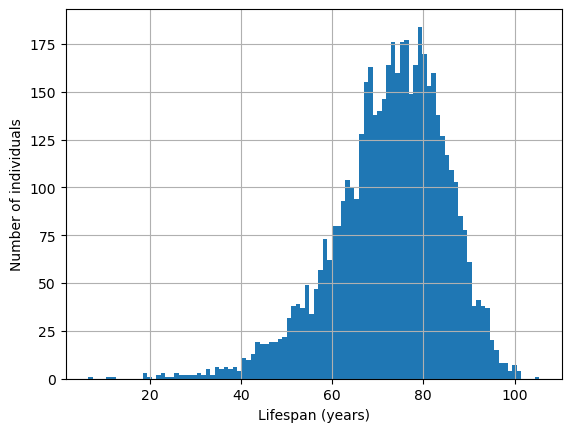

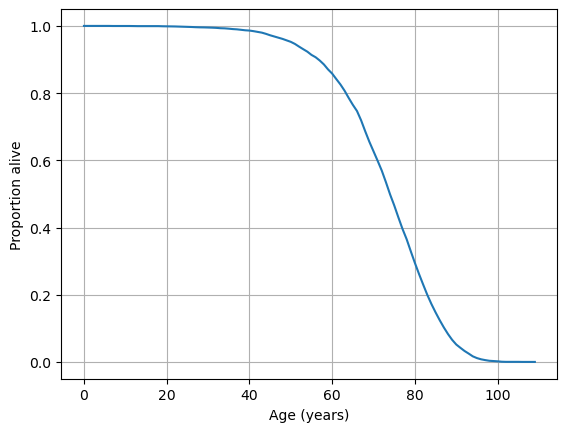

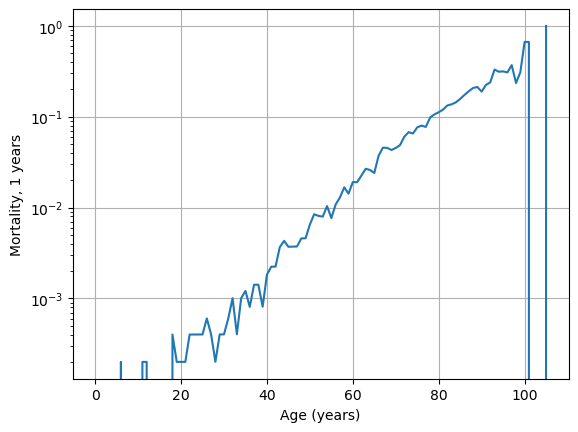

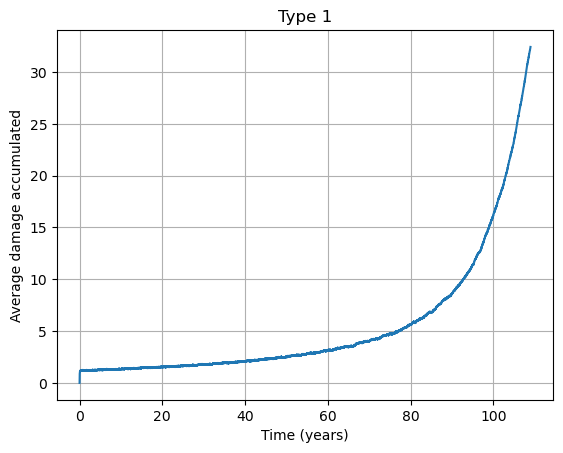

In [11]:
# Human lifespan simulation

eta = 1.4e-3 * 365.25 #/year²
beta = 0.15 * 365.25 #/year
kappa = 0.5
epsilon = 0.16 * 365.25 #/year
parameters = [eta, beta, kappa, epsilon]
death_parameters = [epsilon]
initial_damage = numpy.zeros(1)

lifespan_array = population_simulation(single_damage_accumulation, brownian_bridge, initial_damage,
                                       population_size=5000, dt=1/365.25,
                                       time_span=[0, 109], time_unit="years", parameters=parameters,
                                       name="Human no intervention")

print("Done")

A simulation was also done with 5000 mice, using the following parameters:

- $\eta = 2.4 \times 10^{-4}$ $\mathrm{day}^{-2}$
- $\beta = 0.15$ $\mathrm{day}^{-1}$
- $\kappa = 0.5$
- $\epsilon = 0.16$ $\mathrm{day}^{-1}$
- Damage cutoff: $x = 17$

where time is measured in days.

Running aging simulation: Mouse no intervention
Average lifespan: 824.7 days
Median lifespan: 830.9 days
Standard deviation in lifespan: 132.9 days
Steepness: 6.205
99th percentile: 1107 days


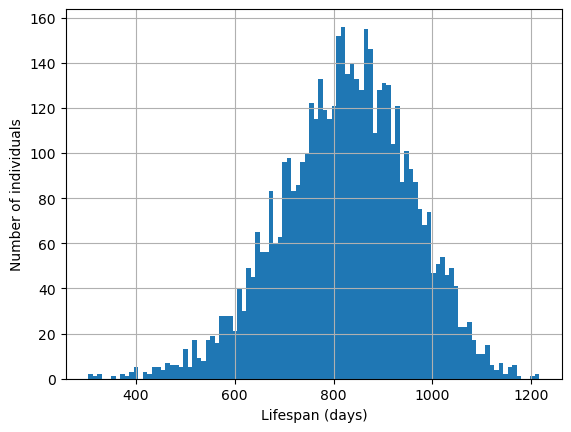

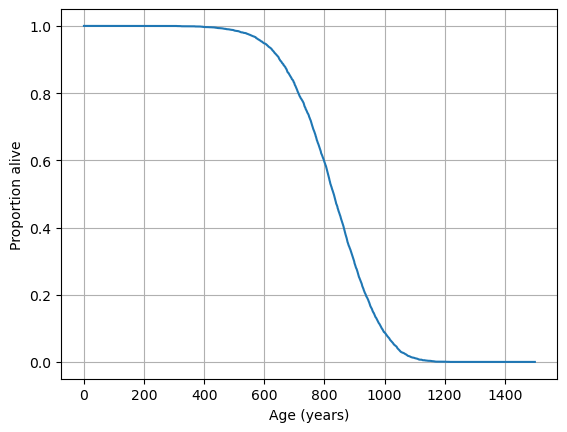

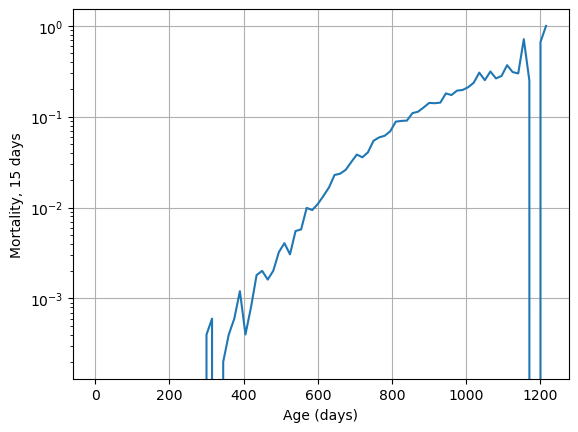

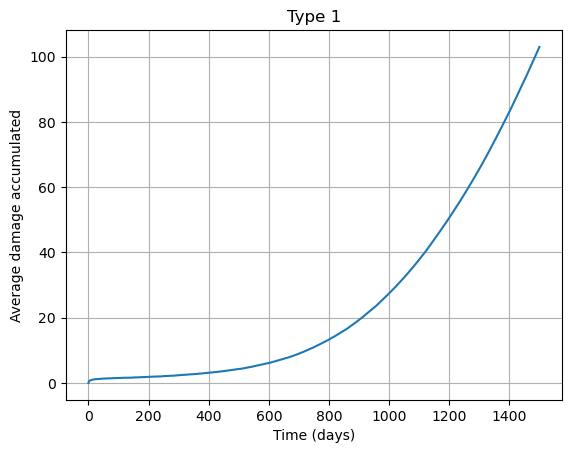

In [12]:
# Mouse lifespan simulation
    
eta = 2.4e-4 #/day²
beta = 0.15 #/day
kappa = 0.5
epsilon = 0.16 #/year
parameters = [eta, beta, kappa, epsilon]
death_parameters = [epsilon]
initial_damage = numpy.zeros(1)

lifespan_array = population_simulation(single_damage_accumulation, brownian_bridge, initial_damage,
                                       population_size=5000, dt=0.1,
                                       time_span=[0, 1500], time_unit="days", parameters=parameters,
                                       death_parameters=death_parameters, name="Mouse no intervention")

Next, the effect of several interventions on lifespan was tested. These include slowing damage accumulation by 30%, increasing the rate of repair by 30% and directly repairing 50% of the damage. All interventions were applied at an age of 800 days.

In [20]:
# Function that allows for testing the effects of interventions on lifespan

@jit(nopython=True)
def damage_accumulation_perturbation(time, concentrations, dt, xi, parameters):
    """
    Compute the change in damage for a single time step, allowing a parameter to change at a specified onset time.

    Parameters:
        time (float): Current time.
        concentrations (array-like): Current damage values.
        dt (float): Time step.
        xi (float): Random normal variable for noise.
        parameters (tuple): Tuple containing:
            - parameter_list (numpy.ndarray): Array of model parameters [eta, beta, kappa, epsilon].
            - parameter_changed (int): Index of the parameter to change.
            - new_value (float): New value for the parameter after onset_time.
            - onset_time (float): Time at which the parameter is changed.

    Returns:
        array-like: Change in damage.
    """
    parameter_list = parameters[0].copy()
    parameter_changed = parameters[1]
    new_value = parameters[2]
    onset_time = parameters[3]
    
    if time >= onset_time:
        parameter_list[parameter_changed] = new_value
    return single_damage_accumulation(time, concentrations, dt, xi, parameter_list)

Running aging simulation: Mouse slowed damage accumulation
Average lifespan: 914 days
Median lifespan: 859.2 days
Standard deviation in lifespan: 226.1 days
Steepness: 4.042
99th percentile: 1424 days


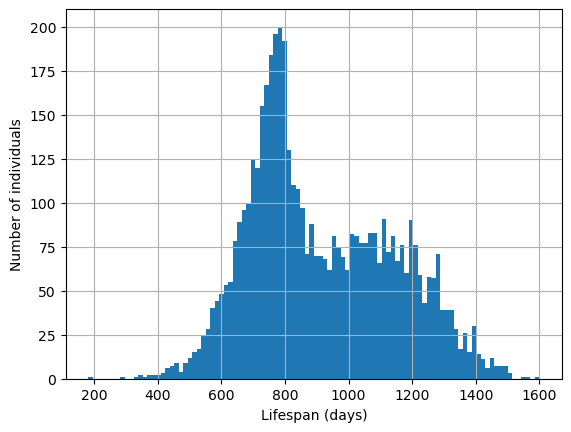

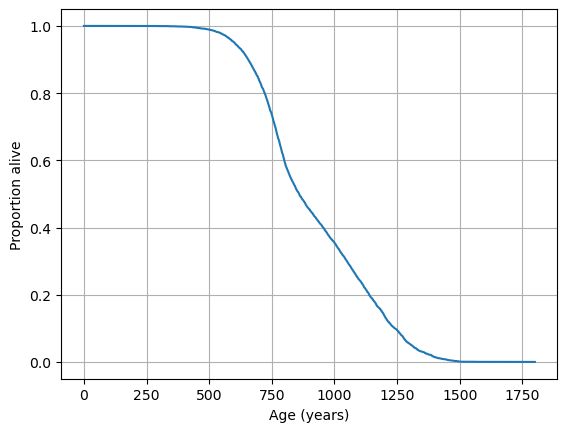

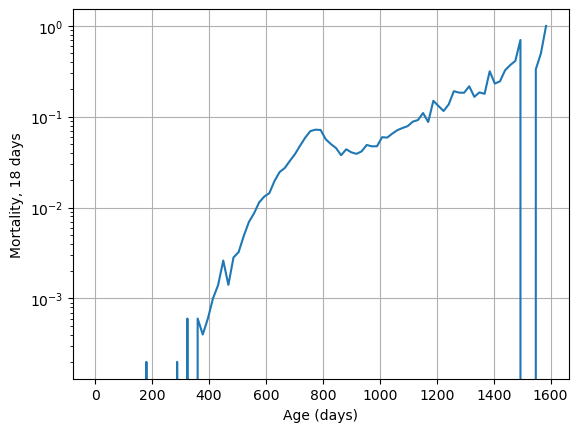

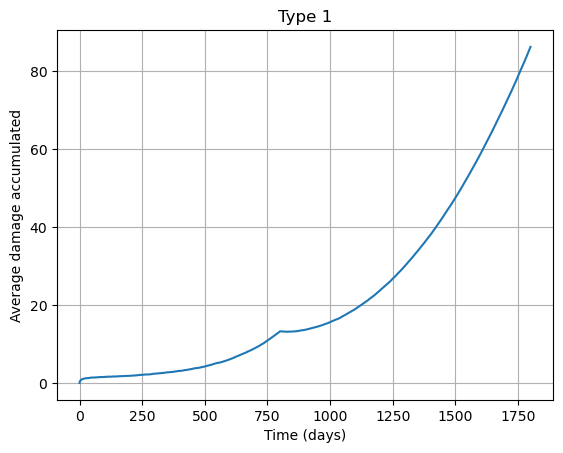

In [21]:
# Slowing damage accumulation at one point in life



eta = 2.4e-4 #/day²
new_eta = 2.4e-4*0.7 #/day²
beta = 0.15 #/day
kappa = 0.5
epsilon = 0.16 #/year
parameters = (numpy.array([eta, beta, kappa, epsilon]), 0, new_eta, 800)
death_parameters = [epsilon]
initial_damage = numpy.zeros(1)

lifespan_array = population_simulation(damage_accumulation_perturbation, brownian_bridge, initial_damage,
                                       population_size=5000, dt=0.1,
                                       time_span=[0, 1800], time_unit="days", parameters=parameters, death_parameters=death_parameters,
                                       name = "Mouse slowed damage accumulation")

Running aging simulation: Mouse increased damage repair
Average lifespan: 871.1 days
Median lifespan: 851 days
Standard deviation in lifespan: 176.4 days
Steepness: 4.94
99th percentile: 1254 days


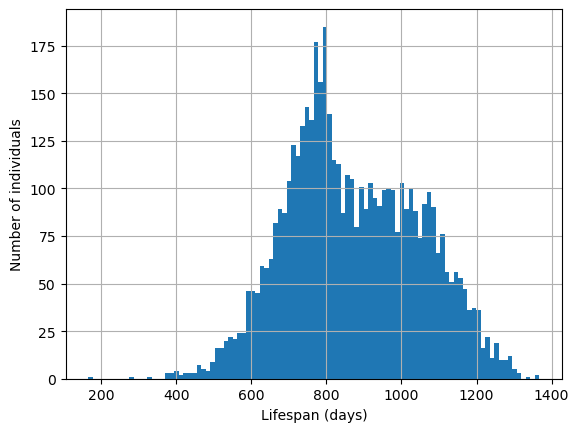

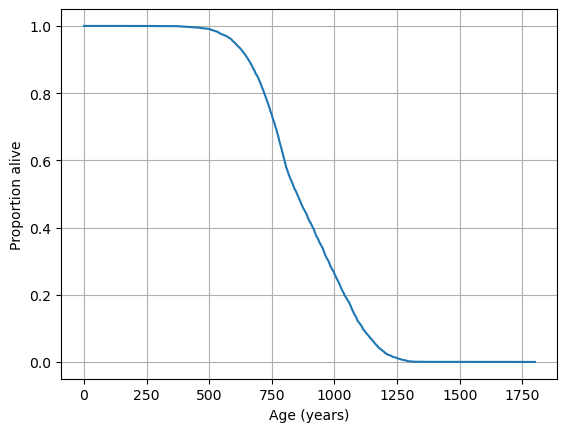

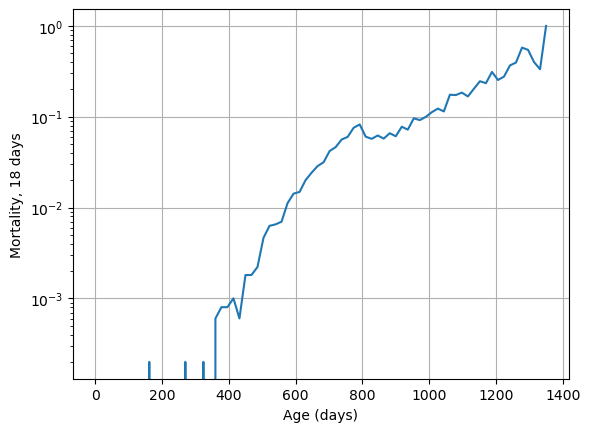

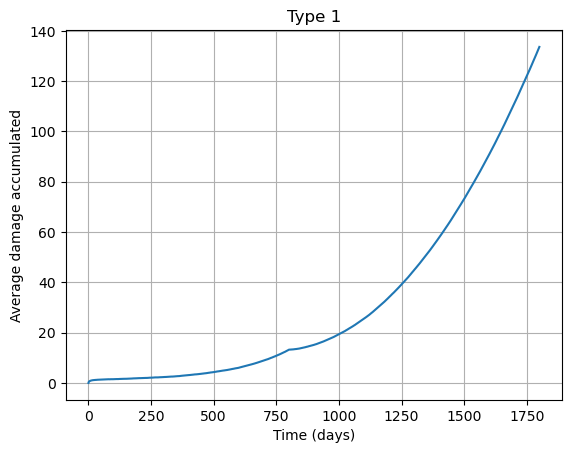

In [22]:
# Increased damage repair

eta = 2.4e-4 #/day²
beta = 0.15 #/day
new_beta = 0.15*1.3 #/day
kappa = 0.5
epsilon = 0.16 #/year
parameters = (numpy.array([eta, beta, kappa, epsilon]), 1, new_beta, 800)
death_parameters = [epsilon]

initial_damage = numpy.zeros(1)

lifespan_array = population_simulation(damage_accumulation_perturbation, brownian_bridge, initial_damage,
                                       population_size=5000, dt=0.1, time_span=[0, 1800],
                                       time_unit="days", parameters=parameters, death_parameters=death_parameters,
                                       name = "Mouse increased damage repair")

Running aging simulation: Mouse direct damage repair
Average lifespan: 851.4 days
Median lifespan: 885.7 days
Standard deviation in lifespan: 151.1 days
Steepness: 5.635
99th percentile: 1135 days


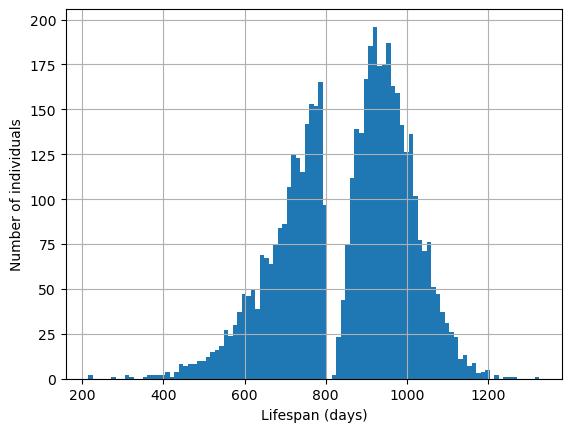

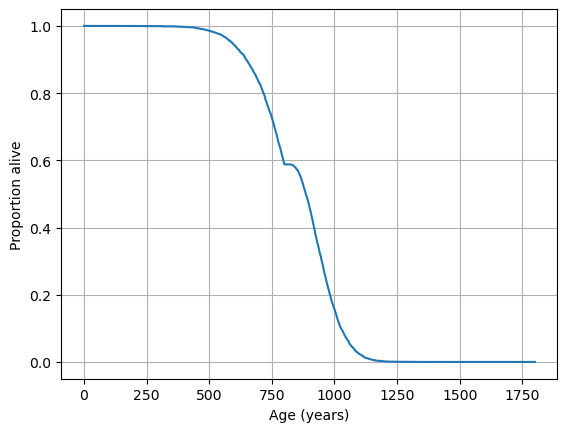

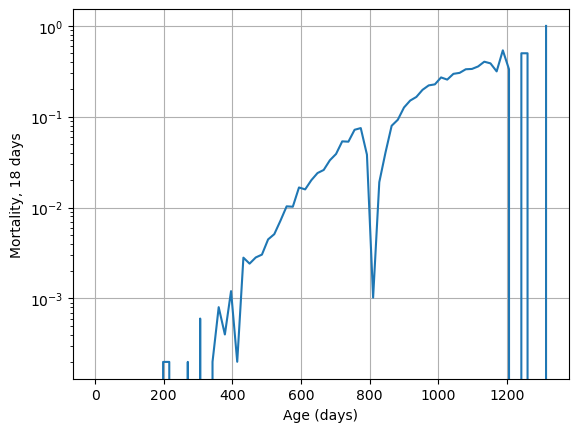

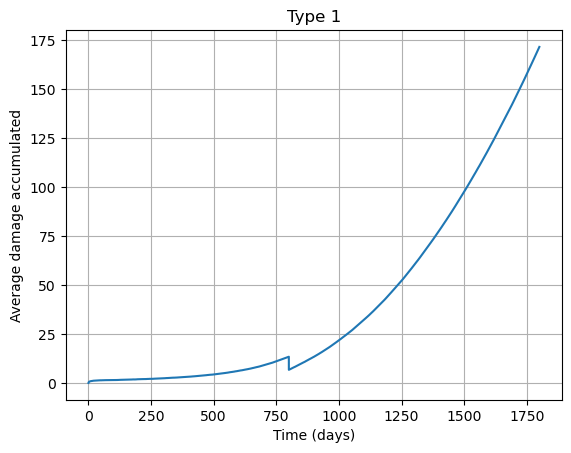

In [26]:
# Intervention directly repairs damage

@jit(nopython=True)
def damage_repair_intervention(time, concentrations, dt, xi, parameters):
    """
    Damage accumulation with a direct repair intervention at a specified time.

    Parameters:
        time (float): Current time.
        concentrations (array-like): Current damage values.
        dt (float): Time step.
        xi (float): Random normal variable for noise.
        parameters (tuple): Tuple containing:
            - parameter_list (numpy.ndarray): Array of model parameters [eta, beta, kappa, epsilon].
            - proportion_repaired (float): Proportion of damage repaired at the intervention.
            - repair_time (float): Time at which repair occurs.

    Returns:
        array-like: Change in damage.
    """
    #parameter_list, proportion_repaired, repair_time
    parameter_list = parameters[0]
    proportion_repaired = parameters[1]
    repair_time = parameters[2]
    if time >= repair_time and time-dt < repair_time:
        # Repair damage
        amount_repaired = concentrations * proportion_repaired
    else:
        amount_repaired = numpy.zeros_like(concentrations)
    return single_damage_accumulation(time, concentrations, dt, xi, parameter_list) - amount_repaired

eta = 2.4e-4 #/day²
beta = 0.15 #/day
kappa = 0.5
epsilon = 0.16 #/year
parameters = (numpy.array([eta, beta, kappa, epsilon]), 0.5, 800)
death_parameters = [epsilon]
initial_damage = numpy.zeros(1)

lifespan_array = population_simulation(damage_repair_intervention, brownian_bridge, initial_damage,
                                       population_size=5000, dt=0.1, time_span=[0, 1800],
                                       time_unit="days", parameters=parameters, death_parameters=death_parameters,
                                       name = "Mouse direct damage repair")

A more complex model with two types of damage was made. Damage of type 1 is accumulated and repaired in the same way as in the previous model. The rate of accumulation for type 2 damage is proportional to the amount of type 1 damage. Only type 2 damage will kill the organism.

For this model, the parameters have not yet been fitted to survival curves from experiments and Brownian bridge adjustment is not implemented yet.

The equations are:

$$
\begin{aligned}
\frac{dA}{dt} &= \eta_1 t - \beta_1 \frac{A}{A + \kappa_1} + \sqrt{2 \epsilon _1} \, \xi \\
\frac{dB}{dt} &= \eta_2 A - \beta_2 \frac{B}{B + \kappa_2} + \sqrt{2 \epsilon _2} \, \xi
\end{aligned}
$$

where:

- $A$ is the amount of type 1 damage
- $B$ is the amount of type 2 damage
- $t$ is time (in days)
- $\eta_1$ is the accumulation rate for type 1 damage
- $\beta_1$ is the repair rate for type 1 damage
- $\kappa_1$ is the repair saturation constant for type 1 damage
- $\epsilon_1$ is the noise amplitude for type 1 damage
- $\eta_2$ is the accumulation rate for type 2 damage (proportional to $A$)
- $\beta_2$ is the repair rate for type 2 damage
- $\kappa_2$ is the repair saturation constant for type 2 damage
- $\epsilon_2$ is the noise amplitude for type 2 damage
- $\xi$ is Gaussian white noise

Parameters used:

- $\eta_1 = 4.4 \times 10^{-4}$ $\mathrm{day}^{-2}$
- $\beta_1 = 0.15$ $\mathrm{day}^{-1}$
- $\kappa_1 = 0.5$
- $\epsilon_1 = 0.16$ $\mathrm{day}^{-1}$
- $\eta_2 = 4.8 \times 10^{-3}$ $\mathrm{day}^{-1}$
- $\beta_2 = 0.15$ $\mathrm{day}^{-1}$
- $\kappa_2 = 0.5$
- $\epsilon_2 = 0.16$ $\mathrm{day}^{-1}$
- Damage cutoff: $B = 17$ (death occurs when type 2 damage exceeds this value)

Running aging simulation: Mouse two damage types
Average lifespan: 800.2 days
Median lifespan: 807.3 days
Standard deviation in lifespan: 99.46 days
Steepness: 8.046
99th percentile: 1006 days


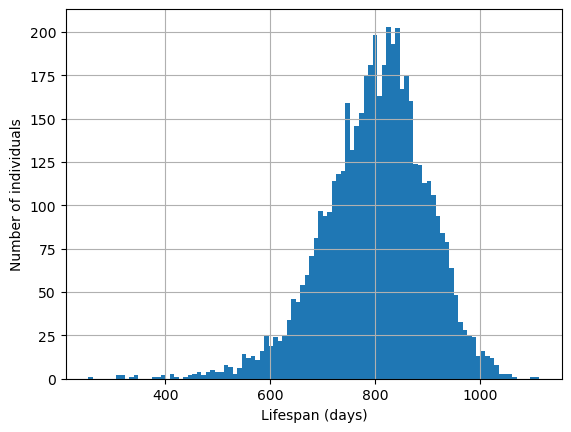

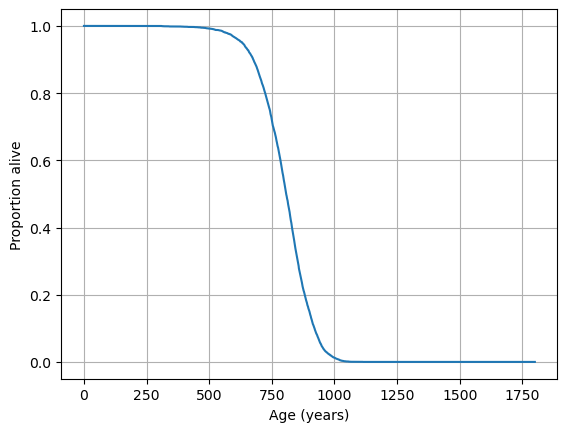

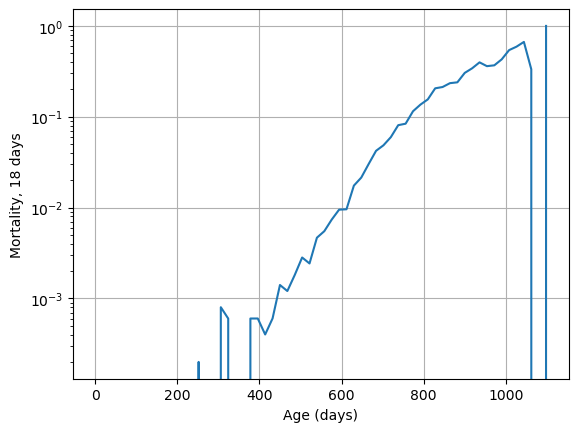

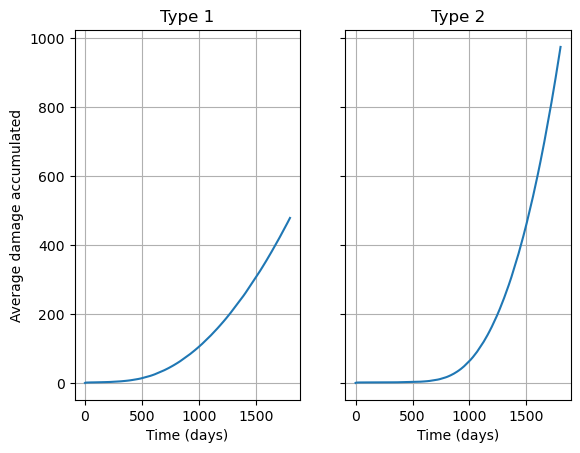

In [25]:
# Two types of damage

@jit(nopython=True)
def type_2_kills(time_array, concentration_matrix, parameters=[]):
    """
    Determine the time index when the second type of damage exceeds the death cutoff.

    Parameters:
        time_array (numpy.ndarray): Array of time points.
        concentration_matrix (numpy.ndarray): Damage values over time (shape: [steps, 2]).
        parameters (array-like, optional): If provided and not empty, the first value is used as the death cutoff.

    Returns:
        float: Time of death (first time when type 2 damage exceeds the cutoff).
    """
    death_cutoff = 17
    death_index = numpy.argmax(concentration_matrix[:, 1] > death_cutoff)
    return time_array[death_index]

@jit(nopython=True)
def two_damage_types(time, concentrations, dt, xi, parameters):
    """
    Determine the time index when the second type of damage exceeds the death cutoff.

    Parameters:
        time_array (numpy.ndarray): Array of time points.
        concentration_matrix (numpy.ndarray): Damage values over time (shape: [steps, 2]).
        parameters (array-like, optional): If provided and not empty, the first value is used as the death cutoff.

    Returns:
        int: Index of death (first time when type 2 damage exceeds the cutoff).
    """
    A_accumulation = parameters[0]
    A_repair = parameters[1]
    A_k = parameters[2]
    A_noise = parameters[3]
    B_accumulation = parameters[4]
    B_repair = parameters[5]
    B_k = parameters[6]
    B_noise = parameters[7]

    A = concentrations[0]
    B = concentrations[1]
    dA = dt * (A_accumulation*time - A_repair*A/(A+A_k)) + \
    numpy.sqrt(2*A_noise*dt)*xi
    dB = dt * (B_accumulation*A    - B_repair*B/(B+B_k)) + \
    numpy.sqrt(2*B_noise*dt)*xi
    return numpy.array([dA, dB])

A_accumulation = 4.4e-4
A_repair = 0.15
A_k = 0.5
A_noise = 0.16
B_accumulation = 4.8e-3
B_repair = 0.15
B_k = 0.5
B_noise = 0.16
parameters = (A_accumulation, A_repair, A_k, A_noise, B_accumulation, B_repair, B_k, B_noise)

initial_damage = numpy.zeros(2)

lifespan_array = population_simulation(two_damage_types, type_2_kills, initial_damage,
                                       population_size = 5000, dt = 0.1, time_span=[0, 1800],
                                       time_unit="days", parameters=parameters,
                                       name = "Mouse two damage types")